## Проект от DonorSearch - Кластеризация пользователей
подготовил Дитятев Иван 
tg - @ivdit

#### Цель:
 Разделить пользователей на кластеры. 
 
 Предлагаемые кластеры: 
 - активный донор, 
 - спящий донор, 
 - реактивированный донор, 
 - потерянный.

#### Задачи:
- Предобработка данных.
- Определение оптимального числа кластеров.
- Разделение пользователей на кластеры.
- Определение четких правил, как отнести пользователя к тому или иному кластеру.
- Исследовательский анализ данных.
- Создание презентации.


In [1]:
from typing import Dict, Optional, Tuple, List
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
from sklearn.cluster import DBSCAN, KMeans
from sklearn.preprocessing import StandardScaler
import warnings


warnings.filterwarnings('ignore')


In [2]:
today = datetime.today()


def to_datetime(df: pd.DataFrame, columns: List[str]) -> pd.DataFrame:
    """Переводим во временной формат список колонок."""
    for column in columns:
      if column not in frozenset(df.columns):
        raise ValueError(f'Column {column} not in dataframe')
      df[column] = pd.to_datetime(df[column], format='%d.%m.%Y',  errors='coerce')
    return df


def to_int(df: pd.DataFrame, columns: List[str]) -> pd.DataFrame:
    """Переводим в int формат список колонок."""
    for column in columns:
      if column not in frozenset(df.columns):
        raise ValueError(f'Column {column} not in dataframe')
      df[column] = df[column].astype(int, errors='ignore')
    return df


def remove_duplicates(df: pd.DataFrame) -> pd.DataFrame:
    """Удаляем дубликаты."""
    return df.drop_duplicates()


def remove_columns(df: pd.DataFrame, columns: List[str]) -> pd.DataFrame:
    """
    Удаляет указанные колонки из DataFrame.
    """
    return df.drop(columns=columns)


def apply_dbscan_in_batches(X: List[List[float]], batch_size: int, eps: float, min_samples: int) -> List[int]:
    """Разбиваем выборку на части и объединяем результат."""
    labels = np.full(X.shape[0], -1)
    for i in range(0, X.shape[0], batch_size):
        batch = X[i:i + batch_size]
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        batch_labels = dbscan.fit_predict(batch)
        labels[i:i + batch_size] = batch_labels
    return labels


def t_test_with_bonferroni(df: pd.DataFrame, column: str) -> Dict[str, Dict[str, float]]:
    """Тест Стьюдента с поправкой Бонферонни и проверкой нормальности распределения."""
    clusters = df['Кластер'].unique()
    results = {}
    num_tests = len(clusters) * (len(clusters) - 1) / 2
    alpha = 0.05 / num_tests
    for i in range(len(clusters)):
        for j in range(i+1, len(clusters)):
            cluster1 = df[df['Кластер'] == clusters[i]][column].dropna()
            cluster2 = df[df['Кластер'] == clusters[j]][column].dropna()
            shapiro_cluster1 = stats.shapiro(cluster1)
            shapiro_cluster2 = stats.shapiro(cluster2)
            if shapiro_cluster1.pvalue > 0.05 and shapiro_cluster2.pvalue > 0.05:
                t_stat, p_value = stats.ttest_ind(cluster1, cluster2, nan_policy='omit')
            else:
                t_stat, p_value = stats.mannwhitneyu(cluster1, cluster2, alternative='two-sided')
            results[f'{clusters[i]} vs {clusters[j]}'] = {'stat': t_stat, 'p_value': p_value, 'significant': p_value < alpha}
    return results


def chi_square_test(data: pd.DataFrame, column: str) -> Tuple[float]:
    """Хи-квадрат тест."""
    contingency_table = pd.crosstab(data[column], data['Кластер'])
    chi2, p, dof, expected = stats.chi2_contingency(contingency_table)
    return chi2, p


def calculate_age(birthdate: Optional[pd.Timestamp]) -> Optional[int]:
    """Вычисляет возраст на основе даты рождения."""
    if pd.isnull(birthdate) or birthdate is pd.NaT:
        return None
    birthdate = pd.to_datetime(birthdate)
    age = today.year - birthdate.year - ((today.month, today.day) < (birthdate.month, birthdate.day))
    return age


def days_since_last_activity(last_activity_date: Optional[pd.Timestamp]) -> Optional[int]:
    """Вычисляет количество дней, прошедших с последней активности."""
    if pd.isnull(last_activity_date) or last_activity_date is pd.NaT:
        return None
    last_activity_date = pd.to_datetime(last_activity_date)
    days_passed = (today - last_activity_date).days
    return days_passed


def elbow_method(data: pd.DataFrame) -> None:
    """Метод локтя."""
    distortions = []
    K = range(1, 11)
    for k in K:
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(data)
        distortions.append(kmeans.inertia_)
    plt.figure(figsize=(10, 6))
    plt.plot(K, distortions, 'bx-')
    plt.xlabel('Количество кластеров')
    plt.ylabel('Искажение')
    plt.title('Метод "локтя" для определения оптимального количества кластеров')
    plt.show()


def analyze_numeric_columns(df: pd.DataFrame, numeric_columns: List[str]) -> None:
    """Построение графиков для числовых колонок."""
    for column in numeric_columns:
        plt.figure(figsize=(10, 6))
        sns.boxplot(x='Кластер', y=column, data=df)
        plt.title(f'Boxplot для {column} по кластерам')
        plt.show()


def analyze_categorical_columns(df: pd.DataFrame, categorical_columns: List[str]) -> None:
    """Построение графиков для категориальных колонок."""
    for column in set(categorical_columns) - set(['Регион']):
        plt.figure(figsize=(10, 6))
        sns.countplot(x='Кластер', hue=column, data=df)
        plt.title(f'Столбчатая диаграмма для {column} по кластерам')
        plt.show()

In [3]:
# table User
user_data = pd.read_csv('C:/Dev/donorsearch/donorsearch_test/DonorSearch2024/users_anon_data.csv')
user_data = to_datetime(user_data, ['Дата регистрации', 'Дата рождения', 'Отвод от донации', 'Последняя активность'])
user_data = to_int(user_data, ['Донаций на момент регистрации', 'Донаций до регистрации'])
user_data = remove_duplicates(user_data)
user_data = remove_columns(user_data, ['Почетный донор', 'Получен значок 20', 'Получен значок 75', 'Получен значок 100', 'Получен значок 150', 'Получен значок друг DS', 'Отправлена футболка', 'Отправлен браслет', 'Донаций с 1 января'])
display(user_data.head())
user_data.info()
user_data.describe()


# table User_Bonus
user_bonus = pd.read_csv('C:/Dev/donorsearch/donorsearch_test/DonorSearch2024/user_bonus_anon.csv')
display(user_bonus.head())


# table Donation
donations = pd.read_csv('C:/Dev/donorsearch/donorsearch_test/DonorSearch2024/donations_anon.csv')
donations = to_datetime(donations, ['Дата донации', 'Дата планирования', 'Дата добавления донации'])
donations = donations.drop_duplicates()
donations = donations[donations['Есть справка'] == 'Да']
donations.info()
display(donations.describe())
display(donations.head())
display(donations['Статус донации'].unique())
display(donations['Есть справка'].value_counts())
df = donations.groupby(by='ID пользователя').agg({'Дата донации': lambda x: x.diff().dt.days.abs().mean(), 'ID': 'count'}).rename(columns={'Дата донации':'Средний интервал между донациями', 'ID': 'Количество донаций'}).fillna(0)
display(df.head())
df.info()
display(df.describe())


# table Plan_Donation
donations_plan = pd.read_csv('C:/Dev/donorsearch/donorsearch_test/DonorSearch2024/anon_donations_plan.csv')
display(donations_plan.head())


# table Bonuse
bonuses = pd.read_csv('C:/Dev/donorsearch/donorsearch_test/DonorSearch2024/bonuses_anon.csv')
bonuses.head()

,ID,Пол,Дата рождения,Регион,Группа крови,Kell-фактор,Готов сдавать Цельную кровь,Готов сдавать Плазму,Готов сдавать Тромбоциты,Готов сдавать Эритроциты,...,Указан email,Указан телефон,Авторизация через ВК,Авторизация через Одноклассники,Авторизация через Твиттер,Авторизация через Яндекс,Авторизация через Гугл,Подтверждённые донации,Донаций на момент регистрации,Количество взятых бонусов
0,300328,Не указано,NaT,"Россия, Тверская область, Тверь",Не указано,Не указано,Да,Да,Да,Да,...,да,нет,да,нет,нет,нет,нет,0,Не указано,0
1,300327,Мужской,1971-12-08,Не указано,Не указано,Не указано,Да,Да,Да,Да,...,да,да,нет,нет,нет,нет,нет,0,Не указано,0
2,300326,Не указано,NaT,"Россия, Москва",Не указано,Не указано,Да,Да,Да,Да,...,да,нет,нет,нет,нет,нет,нет,0,Не указано,0
3,300325,Не указано,NaT,Не указано,Не указано,Не указано,Да,Да,Да,Да,...,да,нет,нет,нет,нет,нет,нет,0,Не указано,0
4,300324,Мужской,1971-10-12,Не указано,Не указано,Не указано,Да,Да,Да,Да,...,да,да,нет,нет,нет,нет,нет,0,Не указано,0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 286913 entries, 0 to 286912
Data columns (total 34 columns):
 #   Column                           Non-Null Count   Dtype         
---  ------                           --------------   -----         
 0   ID                               286913 non-null  int64         
 1   Пол                              286913 non-null  object        
 2   Дата рождения                    107507 non-null  datetime64[ns]
 3   Регион                           286913 non-null  object        
 4   Группа крови                     286913 non-null  object        
 5   Kell-фактор                      286913 non-null  object        
 6   Готов сдавать Цельную кровь      286913 non-null  object        
 7   Готов сдавать Плазму             286913 non-null  object        
 8   Готов сдавать Тромбоциты         286913 non-null  object        
 9   Готов сдавать Эритроциты         286913 non-null  object        
 10  Готов сдавать Лейкоциты          286913 non-

,ID пользователя,Количество взятых бонусов,Количество донаций,Название партнера,Бонус,Дата использования,Страна,Регион,Город
0,149473,121,61,Череповецкий марафон,Скидка 10% на участие в Череповецком марафоне,15.08.2024,Россия,NaN,Санкт-Петербург
1,275997,7,2,DonorSearch,10% на мерч от DonorSearch в ЯндексМаркете,25.08.2024,Россия,Ивановская область,Иваново
2,182830,11,22,DonorSearch,10% на мерч от DonorSearch в ЯндексМаркете,25.08.2024,Россия,NaN,Санкт-Петербург
3,174938,2,32,DonorSearch,10% на мерч от DonorSearch в ЯндексМаркете,25.08.2024,Россия,Томская область,Томск
4,279206,4,13,DonorSearch,10% на мерч от DonorSearch в ЯндексМаркете,24.08.2024,Россия,NaN,Москва


<class 'pandas.core.frame.DataFrame'>
Int64Index: 335659 entries, 0 to 356829
Data columns (total 13 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   ID                       335659 non-null  int64         
 1   ID пользователя          335659 non-null  int64         
 2   Класс крови              335659 non-null  object        
 3   Дата донации             335659 non-null  datetime64[ns]
 4   Дата планирования        16316 non-null   datetime64[ns]
 5   Тип донации              335659 non-null  object        
 6   Город                    335659 non-null  object        
 7   Регион                   335659 non-null  object        
 8   Страна                   335659 non-null  object        
 9   Место сдачи              335659 non-null  object        
 10  Есть справка             335659 non-null  object        
 11  Дата добавления донации  335659 non-null  datetime64[ns]
 12  Статус донации  

,ID,ID пользователя
count,335659.000000,335659.000000
mean,184477.115412,179182.734707
std,107772.301210,89032.066151
min,1.000000,4.000000
25%,88393.500000,127473.500000
50%,185482.000000,195840.000000
75%,279547.500000,256432.000000
max,367797.000000,300322.000000


,ID,ID пользователя,Класс крови,Дата донации,Дата планирования,Тип донации,Город,Регион,Страна,Место сдачи,Есть справка,Дата добавления донации,Статус донации
0,367797,210974,Цельная кровь,2023-11-22,NaT,Безвозмездно,Оренбург,Оренбургская область,Россия,"ГБУЗ ""Оренбургская областная станция переливан...",Да,2024-08-25,На модерации
1,367796,146460,Плазма,2024-08-16,2024-08-16,Безвозмездно,Рыбинск,Ярославская область,Россия,"ГБУЗ ЯО ""Рыбинская станция переливания крови""",Да,2024-08-25,На модерации
2,367795,292587,Цельная кровь,2024-08-24,2024-08-24,Безвозмездно,Москва,Не указан,Россия,Центр крови им. Гаврилова (центр в Царицыно),Да,2024-08-25,На модерации
3,367794,300322,Цельная кровь,2024-08-23,NaT,Безвозмездно,Уфа,Башкортостан,Россия,"ГБУЗ ""Республиканская станция переливания крови""",Да,2024-08-25,На модерации
4,367793,300322,Цельная кровь,2024-05-07,NaT,Безвозмездно,Уфа,Башкортостан,Россия,"ГБУЗ ""Республиканская станция переливания крови""",Да,2024-08-25,На модерации


array(['На модерации', 'Принята', 'Удалена', 'Отклонена',
       'На модерации после принятия', 'Без справки'], dtype=object)

Да    335659
Name: Есть справка, dtype: int64

,Средний интервал между донациями,Количество донаций
ID пользователя,,
4,0.000000,1
7,0.000000,1
8,63.000000,3
11,376.250000,5
14,150.384615,14


<class 'pandas.core.frame.DataFrame'>
Int64Index: 47134 entries, 4 to 300322
Data columns (total 2 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Средний интервал между донациями  47134 non-null  float64
 1   Количество донаций                47134 non-null  int64  
dtypes: float64(1), int64(1)
memory usage: 1.1 MB


,Средний интервал между донациями,Количество донаций
count,47134.000000,47134.000000
mean,140.192929,7.121377
std,308.063561,15.118167
min,0.000000,1.000000
25%,0.000000,1.000000
50%,38.500000,2.000000
75%,167.666667,5.000000
max,8898.000000,378.000000


,ID,ID пользователя,Класс крови,Планируемая дата,Дата создания планирования,Тип донации,Регион,Место стадчи,Статус,Есть справка
0,38294,223833,Плазма,16.09.2024,25.08.2024,Безвозмездно,"Россия, Москва","НМИЦ ССХ им. А.Н. Бакулева, ОПК",донация запланирована,Нет
1,38293,300325,Цельная кровь,29.08.2024,25.08.2024,Безвозмездно,"Россия, Санкт-Петербург",Городская станция переливания крови Санкт-Пете...,донация запланирована,Нет
2,38292,300325,Цельная кровь,29.08.2024,25.08.2024,Безвозмездно,"Россия, Воронежская область, Воронеж","ГУЗ ""Воронежская ОКБ №1"", ОПК",планирование отменено,Нет
3,38291,6790,Цельная кровь,23.10.2024,25.08.2024,Безвозмездно,"Россия, Кемеровская область, Кемерово","МУЗ ""ГКБ №3 им. М.А. Подгорбунского"", отделени...",донация запланирована,Нет
4,38290,6790,Цельная кровь,23.10.2024,25.08.2024,Безвозмездно,"Россия, Кемеровская область, Кемерово","МУЗ ""ГКБ №3 им. М.А. Подгорбунского"", отделени...",донация запланирована,Нет


,ID,Изображение бонуса,Изображение партнера,Опубликован?,На главной странице?,Приоритет,Взято промокодов,Всего промокодов,Срок действия,Дата добавления,Города
0,208,Есть,Есть,Нет,Нет,0,1,25,24.08.2024,14.08.2024,Доступен всем
1,207,Есть,Есть,Да,Нет,1000,57,102,31.08.2024,14.08.2024,Доступен всем
2,205,Есть,Есть,Да,Нет,0,2,100,31.08.2024,02.08.2024,Москва
3,204,Есть,Есть,Да,Нет,100,54,1000,31.10.2024,24.07.2024,Доступен всем
4,203,Есть,Есть,Да,Нет,100,57,1000,31.10.2024,24.07.2024,Доступен всем


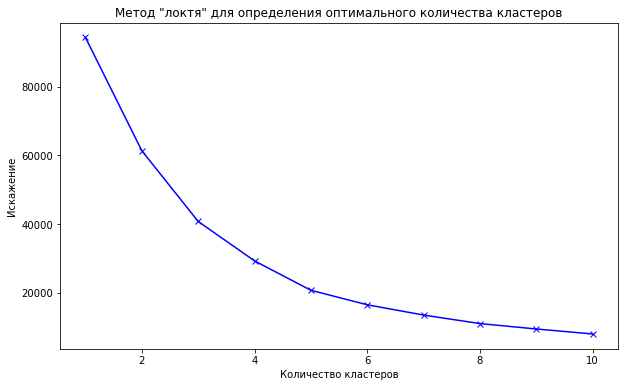

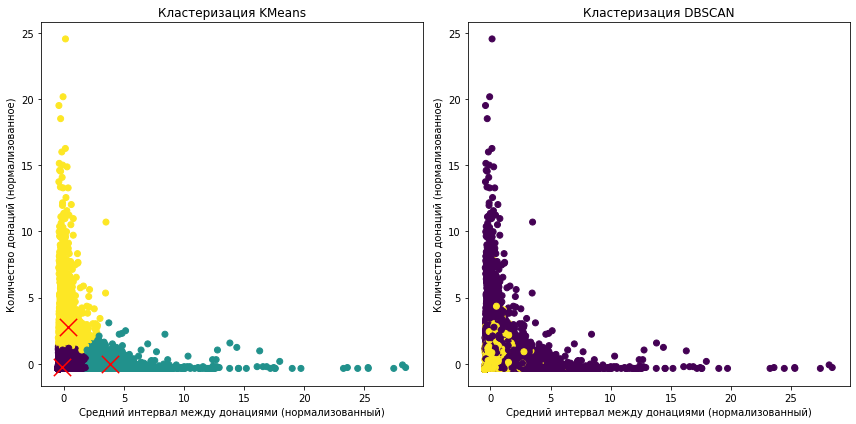

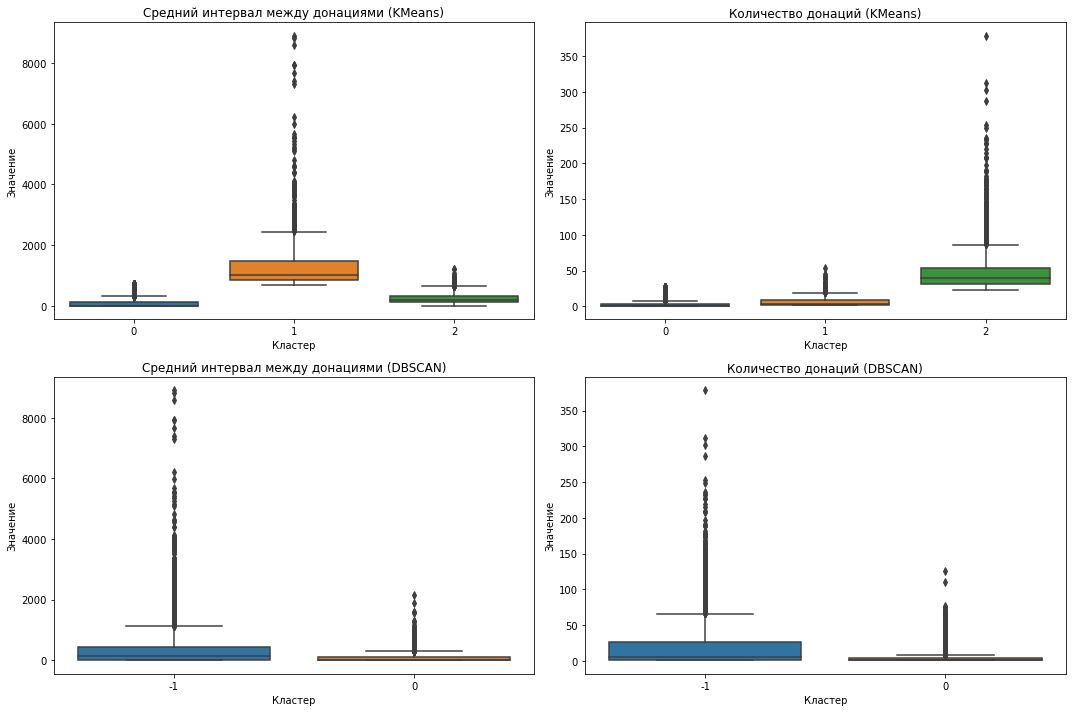

In [4]:
# Нормализация данных
scaler = StandardScaler()
X = df[['Средний интервал между донациями', 'Количество донаций']].values
X_scaled = scaler.fit_transform(X)


# Определение оптимального кол-ва кластеров
elbow_method(X_scaled)


# Кластеризация KMeans
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans_labels = kmeans.fit_predict(X_scaled)


# Визуализация KMeans
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=kmeans_labels, cmap='viridis', marker='o')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='red', marker='x')
plt.xlabel('Средний интервал между донациями (нормализованный)')
plt.ylabel('Количество донаций (нормализованное)')
plt.title('Кластеризация KMeans')


# Применение DBSCAN к мини-пакетам
batch_size = 2
dbscan_labels = apply_dbscan_in_batches(X_scaled, batch_size, eps=1.5, min_samples=2)

# Визуализация DBSCAN
plt.subplot(1, 2, 2)
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=dbscan_labels, cmap='viridis', marker='o')
plt.xlabel('Средний интервал между донациями (нормализованный)')
plt.ylabel('Количество донаций (нормализованное)')
plt.title('Кластеризация DBSCAN')
plt.tight_layout()
plt.show()

# Добавление меток кластеров в DataFrame
df['Кластер_kmeans'] = kmeans_labels
df['Кластер_dbscan'] = dbscan_labels

# Преобразование данных в "long-form" формат для KMeans
df_melted_kmeans = pd.melt(df, id_vars=['Кластер_kmeans'], value_vars=['Средний интервал между донациями', 'Количество донаций'], var_name='Показатель', value_name='Значение')

# Преобразование данных в "long-form" формат для DBSCAN
df_melted_dbscan = pd.melt(df, id_vars=['Кластер_dbscan'], value_vars=['Средний интервал между донациями', 'Количество донаций'], var_name='Показатель', value_name='Значение')

# Создание фигуры с четырьмя подграфиками
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# График для "Средний интервал между донациями" (KMeans)
sns.boxplot(x='Кластер_kmeans', y='Значение', data=df_melted_kmeans[df_melted_kmeans['Показатель'] == 'Средний интервал между донациями'], ax=axes[0, 0])
axes[0, 0].set_title('Средний интервал между донациями (KMeans)')
axes[0, 0].set_xlabel('Кластер')
axes[0, 0].set_ylabel('Значение')

# График для "Количество донаций" (KMeans)
sns.boxplot(x='Кластер_kmeans', y='Значение', data=df_melted_kmeans[df_melted_kmeans['Показатель'] == 'Количество донаций'], ax=axes[0, 1])
axes[0, 1].set_title('Количество донаций (KMeans)')
axes[0, 1].set_xlabel('Кластер')
axes[0, 1].set_ylabel('Значение')

# График для "Средний интервал между донациями" (DBSCAN)
sns.boxplot(x='Кластер_dbscan', y='Значение', data=df_melted_dbscan[df_melted_dbscan['Показатель'] == 'Средний интервал между донациями'], ax=axes[1, 0])
axes[1, 0].set_title('Средний интервал между донациями (DBSCAN)')
axes[1, 0].set_xlabel('Кластер')
axes[1, 0].set_ylabel('Значение')

# График для "Количество донаций" (DBSCAN)
sns.boxplot(x='Кластер_dbscan', y='Значение', data=df_melted_dbscan[df_melted_dbscan['Показатель'] == 'Количество донаций'], ax=axes[1, 1])
axes[1, 1].set_title('Количество донаций (DBSCAN)')
axes[1, 1].set_xlabel('Кластер')
axes[1, 1].set_ylabel('Значение')
plt.tight_layout()
plt.show()

In [5]:
# Определение четких правил соотнесения кластеров
grouped = df_melted_kmeans.groupby(by=['Кластер_kmeans', 'Показатель']).describe()
grouped[('Значение', 'lb')] = grouped[('Значение', '25%')] - 1.5 * (grouped[('Значение', '75%')] - grouped[('Значение', '25%')])
grouped[('Значение', 'ub')] = grouped[('Значение', '75%')] + 1.5 * (grouped[('Значение', '75%')] - grouped[('Значение', '25%')])
for column in [('Значение', 'ub'), ('Значение', 'lb')]:
    grouped[column] = grouped[column].apply(lambda x: x if x >=0 else 0)
display(grouped)

Значение               \
                                                   count         mean   
Кластер_kmeans Показатель                                               
0              Количество донаций                42117.0     3.668732   
               Средний интервал между донациями  42117.0    88.429292   
1              Количество донаций                 1541.0     7.087605   
               Средний интервал между донациями   1541.0  1333.044690   
2              Количество донаций                 3476.0    48.970368   
               Средний интервал между донациями   3476.0   238.565930   

                                                                         \
                                                        std         min   
Кластер_kmeans Показатель                                                 
0              Количество донаций                  5.034566    1.000000   
               Средний интервал между донациями  137.370565    0.000000   
1              Количество донаций                  7.002930    2.000000   
               Средний интервал между донациями  897.247542  698.421053   
2              Количество донаций                 29.576969   23.000000   
               Средний интервал между донациями  169.094264    0.000000   

                                                                          \
                                                        25%          50%   
Кластер_kmeans Показатель                                                  
0              Количество донаций                  1.000000     1.000000   
               Средний интервал между донациями    0.000000     0.000000   
1              Количество донаций                  2.000000     4.000000   
               Средний интервал между донациями  832.666667  1026.681818   
2              Количество донаций                 31.000000    40.000000   
               Средний интервал между донациями  112.226829   195.458042   

                                                                              \
                                                         75%          max lb   
Кластер_kmeans Показатель                                                      
0              Количество донаций                   4.000000    27.000000  0   
               Средний интервал между донациями   130.666667   712.000000  0   
1              Количество донаций                   9.000000    54.000000  0   
               Средний интервал между донациями  1477.166667  8898.000000  0   
2              Количество донаций                  53.000000   378.000000  0   
               Средний интервал между донациями   323.083333  1220.928571  0   

                                                              
                                                          ub  
Кластер_kmeans Показатель                                     
0              Количество донаций                   8.500000  
               Средний интервал между донациями   326.666667  
1              Количество донаций                  19.500000  
               Средний интервал между донациями  2443.916667  
2              Количество донаций                  86.000000  
               Средний интервал между донациями   639.368090

Пример запроса:
```sql
SELECT *,
    CASE
        WHEN Количество_донаций BETWEEN 0 AND 8.5 AND Средний_интервал_между_донациями BETWEEN 0 AND 327.8125 THEN 0
        WHEN Количество_донаций BETWEEN 0 AND 87 AND Средний_интервал_между_донациями BETWEEN 0 AND 634.791103 THEN 1
        WHEN Количество_донаций BETWEEN 0 AND 19.5 AND Средний_интервал_между_донациями BETWEEN 0 AND 2444.117716 THEN 2
        ELSE 3
    END AS Кластер
FROM some_table;
```

In [6]:
# Присоединяем кластеры к пользователям
df.reset_index(inplace=True)
df = df.rename(columns={'ID пользователя': 'ID'})
user_data = user_data.merge(df[['ID', 'Кластер_kmeans']], on='ID', how='left')
user_data.rename(columns={'Кластер_kmeans': 'Кластер'}, inplace=True)
user_data['Кластер'] = user_data['Кластер'].fillna(3)
user_data['Возраст'] = user_data['Дата рождения'].apply(calculate_age)
user_data['Дни с последней активности'] = user_data['Последняя активность'].apply(days_since_last_activity)
display(user_data)
user_data.info()

,ID,Пол,Дата рождения,Регион,Группа крови,Kell-фактор,Готов сдавать Цельную кровь,Готов сдавать Плазму,Готов сдавать Тромбоциты,Готов сдавать Эритроциты,...,Авторизация через Одноклассники,Авторизация через Твиттер,Авторизация через Яндекс,Авторизация через Гугл,Подтверждённые донации,Донаций на момент регистрации,Количество взятых бонусов,Кластер,Возраст,Дни с последней активности
0,300328,Не указано,NaT,"Россия, Тверская область, Тверь",Не указано,Не указано,Да,Да,Да,Да,...,нет,нет,нет,нет,0,Не указано,0,3.0,NaN,22.0
1,300327,Мужской,1971-12-08,Не указано,Не указано,Не указано,Да,Да,Да,Да,...,нет,нет,нет,нет,0,Не указано,0,3.0,52.0,NaN
2,300326,Не указано,NaT,"Россия, Москва",Не указано,Не указано,Да,Да,Да,Да,...,нет,нет,нет,нет,0,Не указано,0,3.0,NaN,22.0
3,300325,Не указано,NaT,Не указано,Не указано,Не указано,Да,Да,Да,Да,...,нет,нет,нет,нет,0,Не указано,0,3.0,NaN,22.0
4,300324,Мужской,1971-10-12,Не указано,Не указано,Не указано,Да,Да,Да,Да,...,нет,нет,нет,нет,0,Не указано,0,3.0,52.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
286908,117655,Не указано,NaT,"Россия, Санкт-Петербург",Не указано,Не указано,Да,Да,Да,Да,...,нет,нет,нет,нет,0,Не указано,0,3.0,NaN,NaN
286909,149310,Мужской,1981-05-27,"Россия, Санкт-Петербург",A(II) Rh+,Не указано,Да,Да,Да,Да,...,нет,да,да,да,12,1,0,0.0,43.0,149.0
286910,9322,Мужской,NaT,"Россия, Санкт-Петербург",O(I) Rh+,Положительный,Нет,Да,Да,Нет,...,да,нет,нет,нет,39,25,1,2.0,NaN,30.0
286911,8445,Не указано,NaT,"Россия, Санкт-Петербург",Не указано,Не указано,Да,Да,Да,Да,...,нет,нет,нет,нет,0,Не указано,0,3.0,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
Int64Index: 286913 entries, 0 to 286912
Data columns (total 37 columns):
 #   Column                           Non-Null Count   Dtype         
---  ------                           --------------   -----         
 0   ID                               286913 non-null  int64         
 1   Пол                              286913 non-null  object        
 2   Дата рождения                    107507 non-null  datetime64[ns]
 3   Регион                           286913 non-null  object        
 4   Группа крови                     286913 non-null  object        
 5   Kell-фактор                      286913 non-null  object        
 6   Готов сдавать Цельную кровь      286913 non-null  object        
 7   Готов сдавать Плазму             286913 non-null  object        
 8   Готов сдавать Тромбоциты         286913 non-null  object        
 9   Готов сдавать Эритроциты         286913 non-null  object        
 10  Готов сдавать Лейкоциты          286913 non-

In [7]:
# Проверка на статистически значимые различия между признаками с p-value = 0,05
# косвенная проверка успешности распределения
numeric_columns = [
    'Возраст', 'Цельная кровь', 'Плазма', 'Тромбоциты',
    'Эритроциты', 'Лейкоциты', 'Не подтверждённые донации',
    'Прошедших донаций', 'Дни с последней активности',
    'Подтверждённые донации',  'Количество взятых бонусов']
categorical_columns = ['Пол', 'Регион', 'Группа крови', 'Kell-фактор',
       'Готов сдавать Цельную кровь', 'Готов сдавать Плазму',
       'Готов сдавать Тромбоциты', 'Готов сдавать Эритроциты',
       'Готов сдавать Лейкоциты', 'Готов сдавать Костный мозг','Указан email', 'Указан телефон', 'Авторизация через ВК',
       'Авторизация через Одноклассники', 'Авторизация через Твиттер',
       'Авторизация через Яндекс', 'Авторизация через Гугл']


results = {}
for column in numeric_columns:
    results[column] = t_test_with_bonferroni(user_data, column)
for column, res in results.items():
    print(f'Column: {column}')
    for comparison, values in res.items():
        print(f'{comparison}: t_stat = {values["stat"]}, p_value = {values["p_value"]}, significant = {values["significant"]}')
    print('\n')
chi_square_results = {}
for column in categorical_columns:
    chi_square_results[column] = chi_square_test(user_data, column)
for column, (chi2, p) in chi_square_results.items():
    significant = p < 0.05
    print(f'Column: {column}, chi2 = {chi2}, p_value = {p}, significant = {significant}')
    print('\n')


Column: Возраст
3.0 vs 0.0: t_stat = 794681025.0, p_value = 0.8325578797498592, significant = False
3.0 vs 1.0: t_stat = 33884057.5, p_value = 8.083970035895427e-22, significant = True
3.0 vs 2.0: t_stat = 80829021.0, p_value = 1.5852052083546516e-170, significant = True
0.0 vs 1.0: t_stat = 7276749.0, p_value = 2.4394125672664546e-25, significant = True
0.0 vs 2.0: t_stat = 16761658.0, p_value = 5.372373099476046e-194, significant = True
1.0 vs 2.0: t_stat = 1088584.5, p_value = 6.0434073450586555e-18, significant = True


Column: Цельная кровь
3.0 vs 0.0: t_stat = 796012025.5, p_value = 0.0, significant = True
3.0 vs 1.0: t_stat = 9233385.5, p_value = 0.0, significant = True
3.0 vs 2.0: t_stat = 17744442.5, p_value = 0.0, significant = True
0.0 vs 1.0: t_stat = 17305521.5, p_value = 4.162241344315871e-234, significant = True
0.0 vs 2.0: t_stat = 12485693.5, p_value = 0.0, significant = True
1.0 vs 2.0: t_stat = 777092.0, p_value = 0.0, significant = True


Column: Плазма
3.0 vs 0.0: 

Анализ числовых колонок:


Возраст                                                        \
           count       mean        std    min   25%   50%   75%    max   
Кластер                                                                  
0.0      18699.0  32.767314   8.761486    3.0  26.0  32.0  38.0  127.0   
1.0        970.0  35.174227   7.296574    6.0  30.0  35.0  39.0   60.0   
2.0       2757.0  37.463185   7.516974    6.0  33.0  37.0  42.0   91.0   
3.0      85081.0  33.255886  10.672597 -174.0  25.0  32.0  39.0  135.0   

        Цельная кровь             ... Подтверждённые донации         \
                count       mean  ...                    75%    max   
Кластер                           ...                                 
0.0           42117.0   2.742456  ...                    3.0   75.0   
1.0            1541.0   5.931213  ...                    9.0   59.0   
2.0            3476.0  23.278193  ...                   52.0  378.0   
3.0          239779.0   0.000046  ...                    0.0   12.0   

        Количество взятых бонусов                                          \
                            count      mean       std  min  25%  50%  75%   
Кластер                                                                     
0.0                       42117.0  0.476696  1.523538  0.0  0.0  0.0  0.0   
1.0                        1541.0  0.575600  1.424836  0.0  0.0  0.0  1.0   
2.0                        3476.0  1.869678  4.117762  0.0  0.0  0.0  2.0   
3.0                      239779.0  0.000004  0.002042  0.0  0.0  0.0  0.0   

                
           max  
Кластер         
0.0      113.0  
1.0       19.0  
2.0      121.0  
3.0        1.0  

[4 rows x 88 columns]

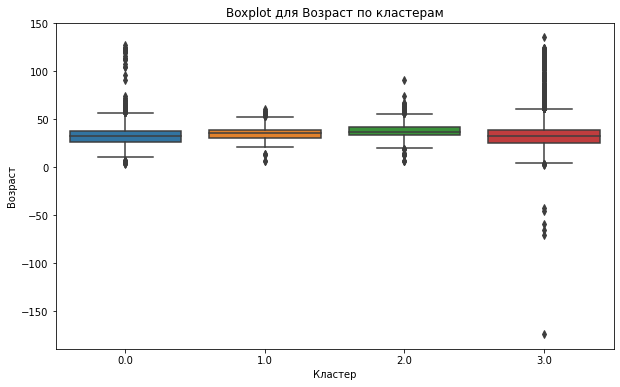

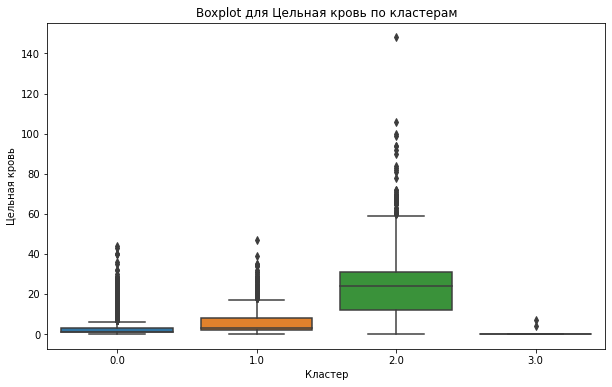

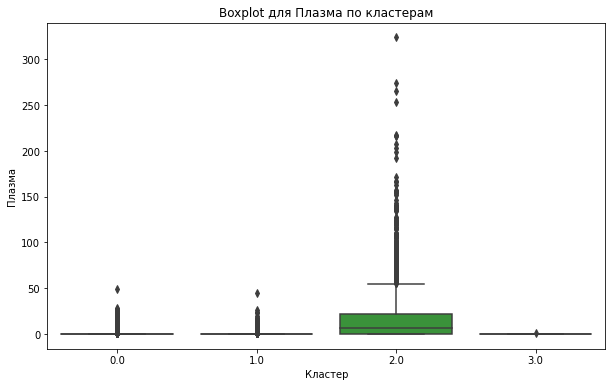

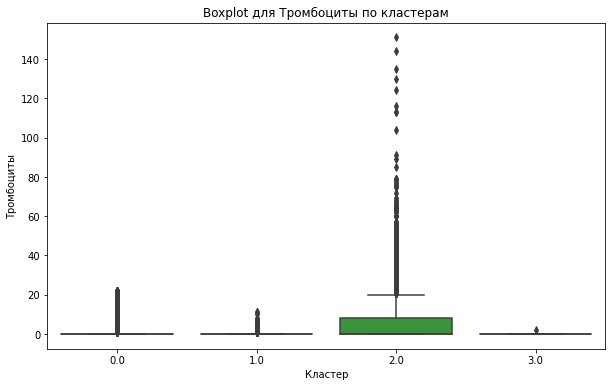

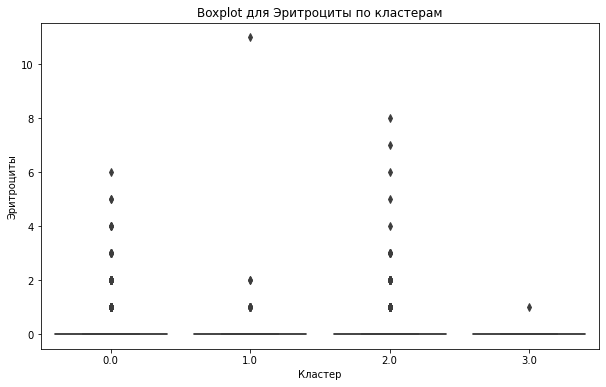

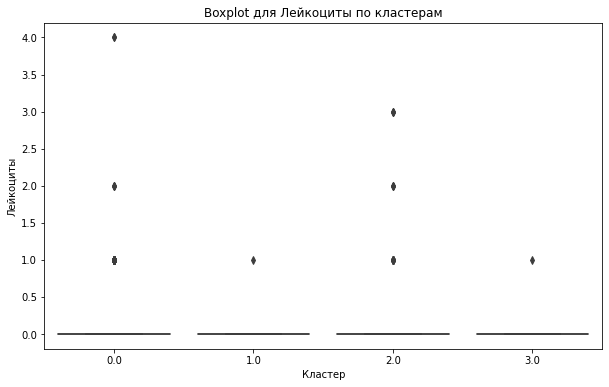

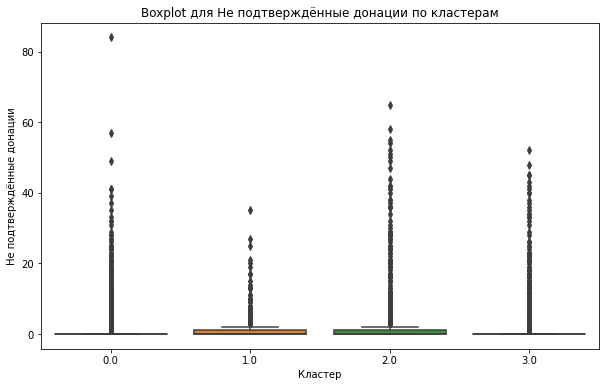

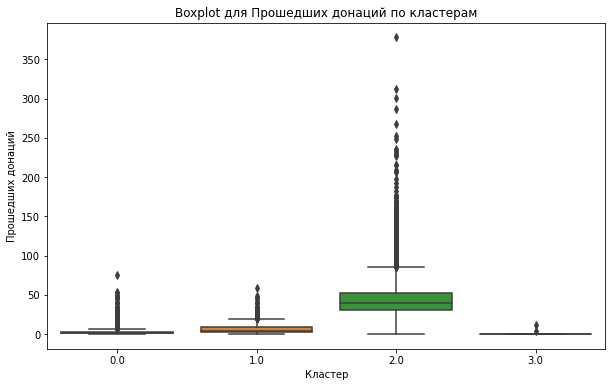

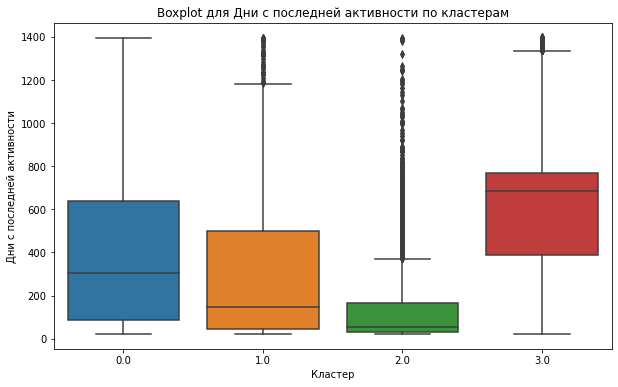

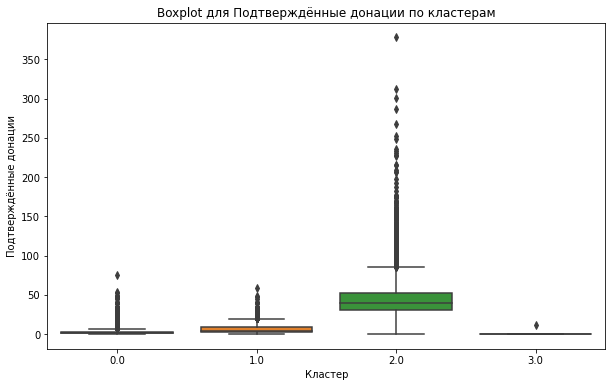

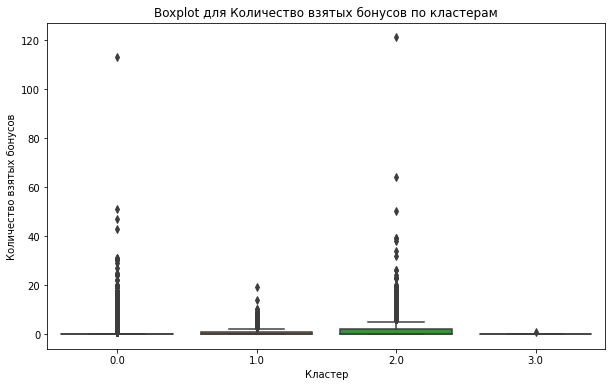


Анализ категориальных колонок:


,Пол,Регион,Группа крови,Kell-фактор,Готов сдавать Цельную кровь,Готов сдавать Плазму,Готов сдавать Тромбоциты,Готов сдавать Эритроциты,Готов сдавать Лейкоциты,Готов сдавать Костный мозг,Указан email,Указан телефон,Авторизация через ВК,Авторизация через Одноклассники,Авторизация через Твиттер,Авторизация через Яндекс,Авторизация через Гугл
Кластер,,,,,,,,,,,,,,,,,
0.0,Не указано,"Россия, Москва",Не указано,Не указано,Да,Да,Да,Да,Да,Нет,да,да,да,нет,нет,нет,нет
1.0,Женский,"Россия, Москва",Не указано,Не указано,Да,Да,Да,Да,Да,Нет,да,да,да,нет,нет,нет,нет
2.0,Мужской,"Россия, Москва",O(I) Rh+,Отрицательный,Да,Да,Да,Да,Да,Нет,да,да,нет,нет,нет,нет,нет
3.0,Не указано,Не указано,Не указано,Не указано,Да,Да,Да,Да,Да,Нет,да,да,нет,нет,нет,нет,нет


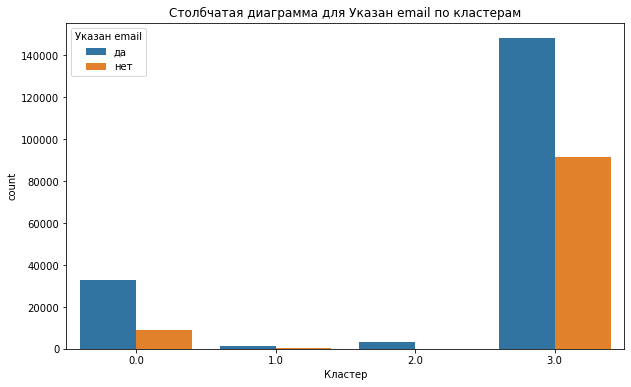

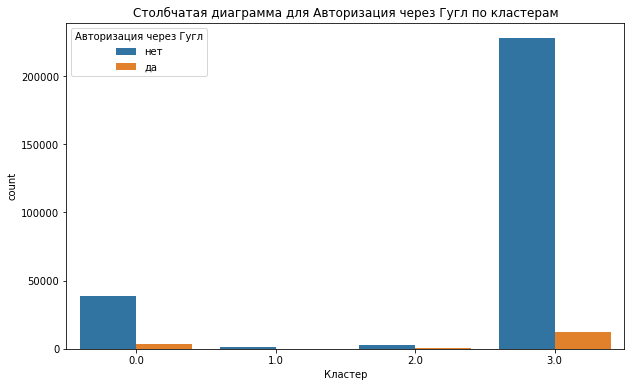

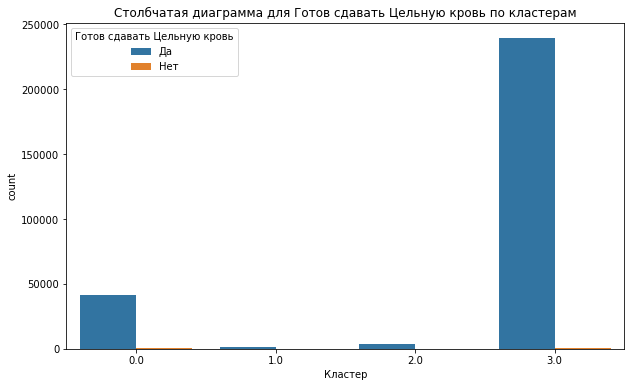

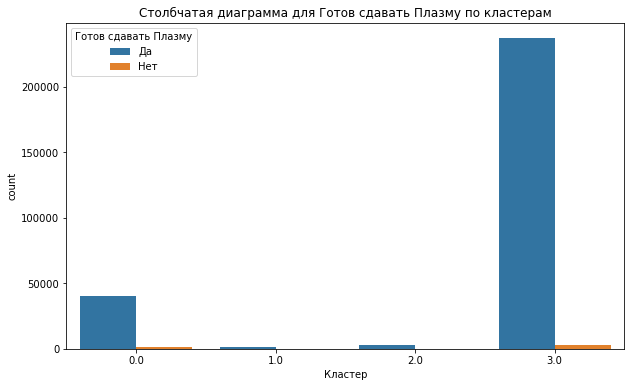

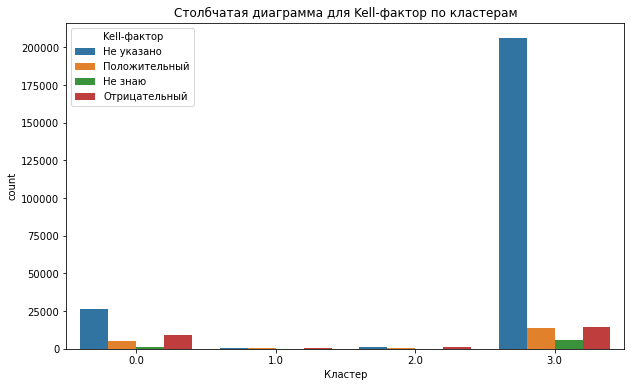

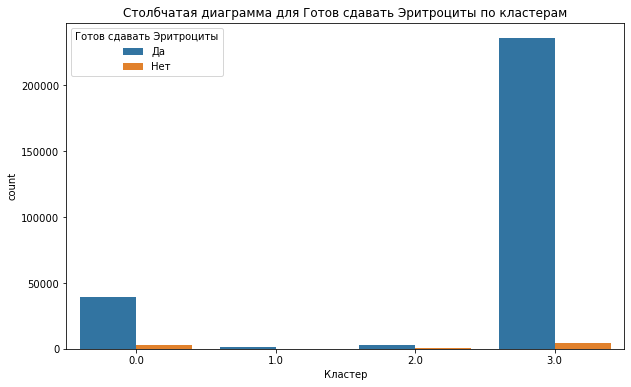

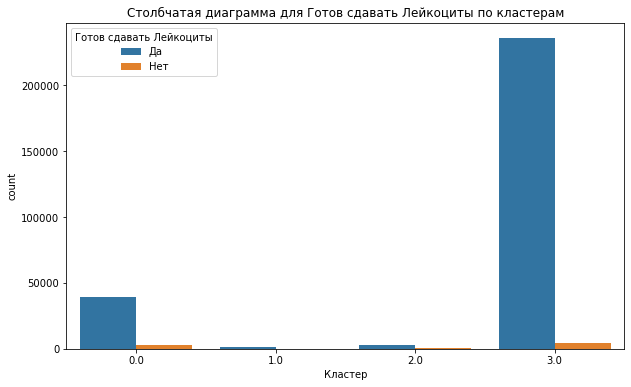

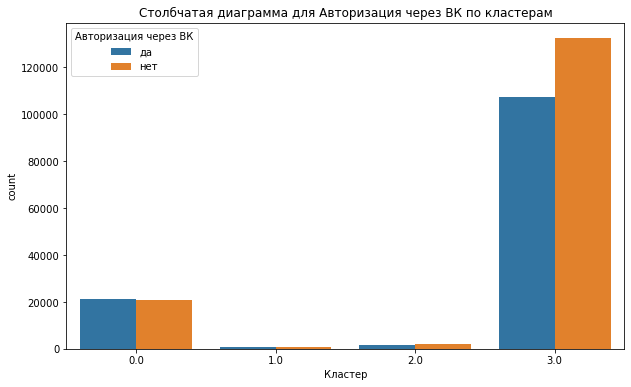

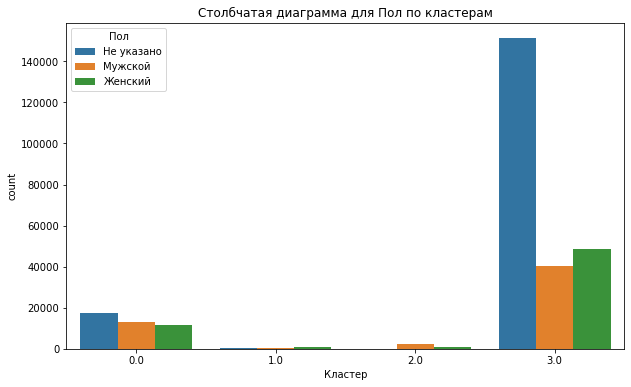

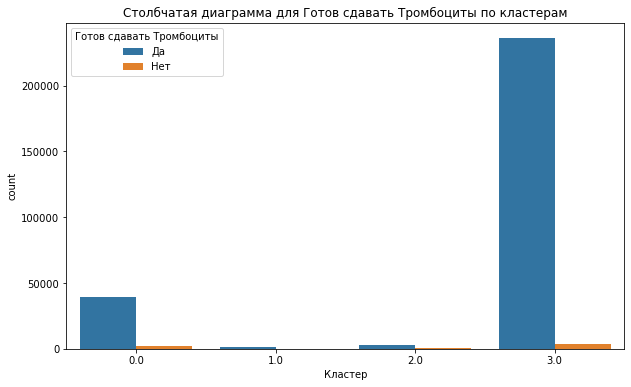

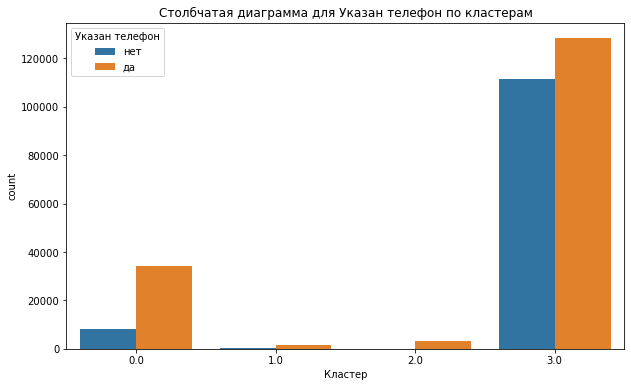

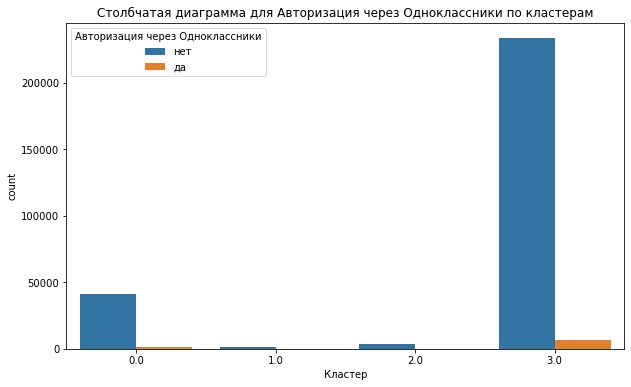

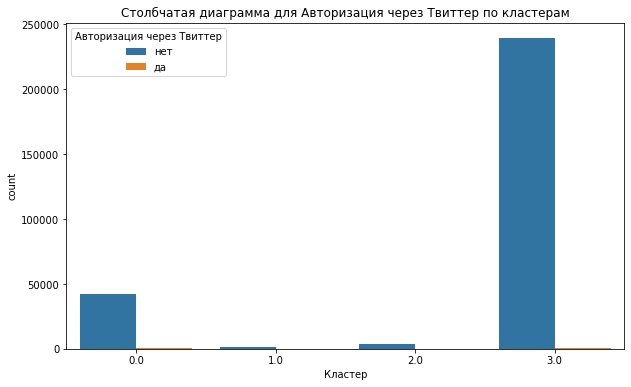

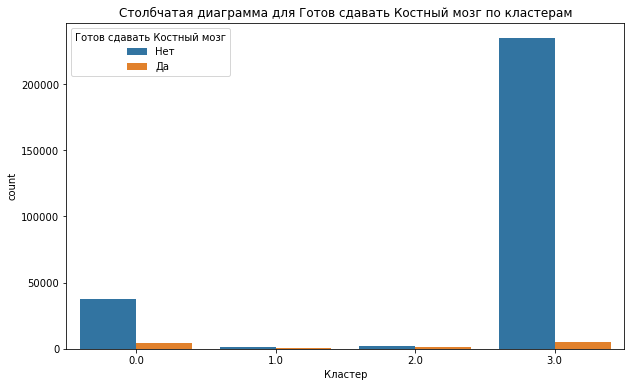

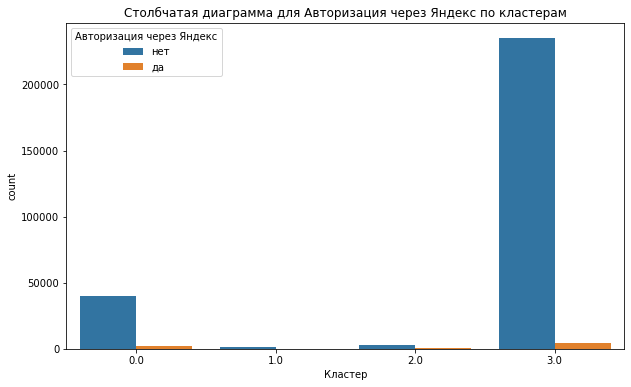

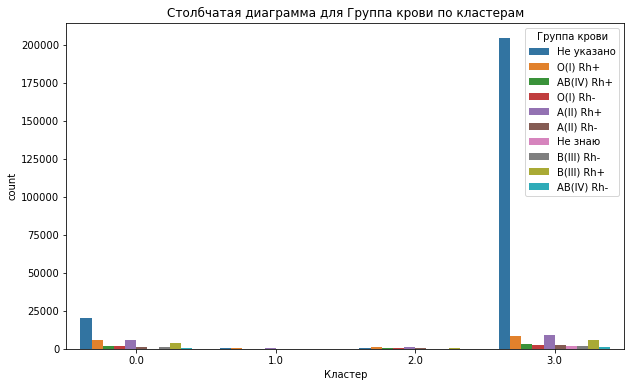

In [8]:
# Анализ числовых колонок
numeric_analysis = user_data.groupby('Кластер')[numeric_columns].describe()

# Анализ категориальных колонок
categorical_analysis = user_data.groupby('Кластер')[categorical_columns].agg(lambda x: x.value_counts().index[0])

# Отображение результатов
print("Анализ числовых колонок:")
display(numeric_analysis)
analyze_numeric_columns(user_data, numeric_columns)
print("\nАнализ категориальных колонок:")
display(categorical_analysis)
analyze_categorical_columns(user_data, categorical_columns)


[Презентация](https://disk.yandex.ru/i/PXxISmPi5zQViA)